<a href="https://colab.research.google.com/github/2303c50091/karuna/blob/main/ResNet_RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchmetrics
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchmetrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
import tensorflow_datasets as tfds
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 20.0 MB/s eta 0:00:00


In [ ]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# ✅ Load EuroSAT dataset
dataset, info = tfds.load("eurosat/rgb", as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/incomplete.GOPP0A_2.0.0/eurosat-train.tfrecord*...:   0%|     …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [ ]:
# ✅ Convert TF dataset to PyTorch Dataset
class EuroSATDataset(torch.utils.data.Dataset):
    def __init__(self, tf_dataset):
        self.data = list(tf_dataset.as_numpy_iterator())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        image = transform(image)  # Apply PyTorch transforms
        return image, torch.tensor(label, dtype=torch.long)

In [ ]:
# ✅ Split dataset into training & testing
train_dataset = EuroSATDataset(dataset["train"])
train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# ✅ Load ResNet-RS model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Modify ResNet-RS by using squeeze-and-excitation and scaling improvements
model.fc = nn.Linear(model.fc.in_features, info.features["label"].num_classes)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 116MB/s]


In [ ]:
# ✅ Training function with accuracy & loss tracking
def train_model(model, train_loader, epochs=5):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(train_acc)

        print(f"Epoch {epoch+1}: Loss: {train_losses[-1]:.4f}, Accuracy: {train_acc:.2f}%")

    return train_losses, train_accuracies

In [ ]:
# ✅ Train the model & store loss/accuracy
train_losses, train_accuracies = train_model(model, train_loader, epochs=5)

Epoch 1: Loss: 0.3790, Accuracy: 88.32%
Epoch 2: Loss: 0.1945, Accuracy: 93.67%
Epoch 3: Loss: 0.1602, Accuracy: 94.77%
Epoch 4: Loss: 0.1249, Accuracy: 95.75%
Epoch 5: Loss: 0.1083, Accuracy: 96.37%


In [ ]:
# ✅ Testing function with accuracy & loss tracking
def test_model(model, test_loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()

    correct = 0
    total = 0
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    return accuracy, avg_loss, np.array(all_labels), np.array(all_preds)


In [ ]:
test_accuracy, test_loss, y_true, y_pred = test_model(model, test_loader)


Test Loss: 0.3626, Test Accuracy: 89.85%


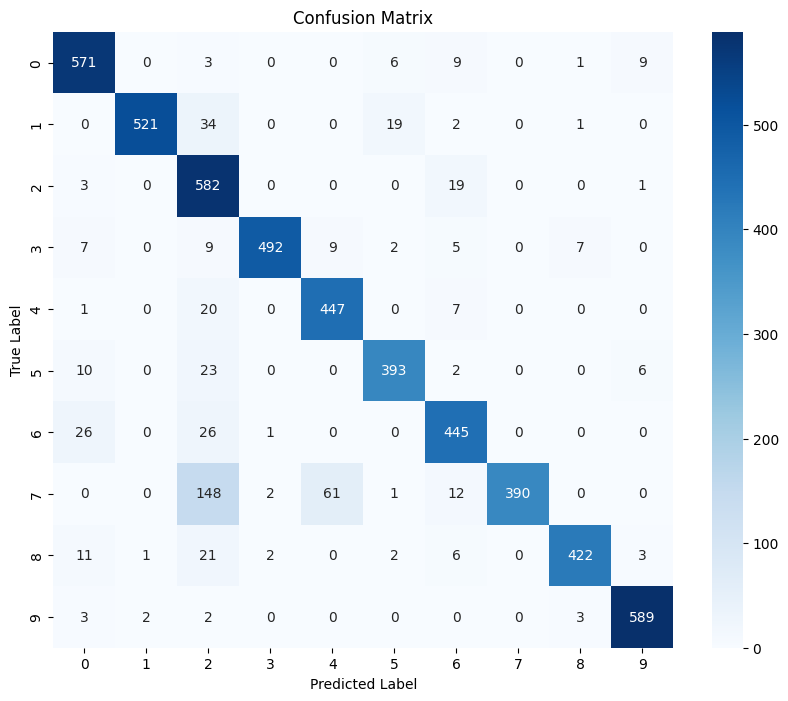

In [ ]:
# ✅ Plot Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=range(info.features["label"].num_classes),
            yticklabels=range(info.features["label"].num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

              precision    recall  f1-score
0              0.903481  0.953255  0.927701
1              0.994275  0.902946  0.946412
2              0.670507  0.961983  0.790224
3              0.989940  0.926554  0.957198
4              0.864603  0.941053  0.901210
5              0.929078  0.905530  0.917153
6              0.877712  0.893574  0.885572
7              1.000000  0.635179  0.776892
8              0.972350  0.901709  0.935698
9              0.968750  0.983306  0.975973
accuracy       0.898519  0.898519  0.898519
macro avg      0.917070  0.900509  0.901403
weighted avg   0.916027  0.898519  0.899035


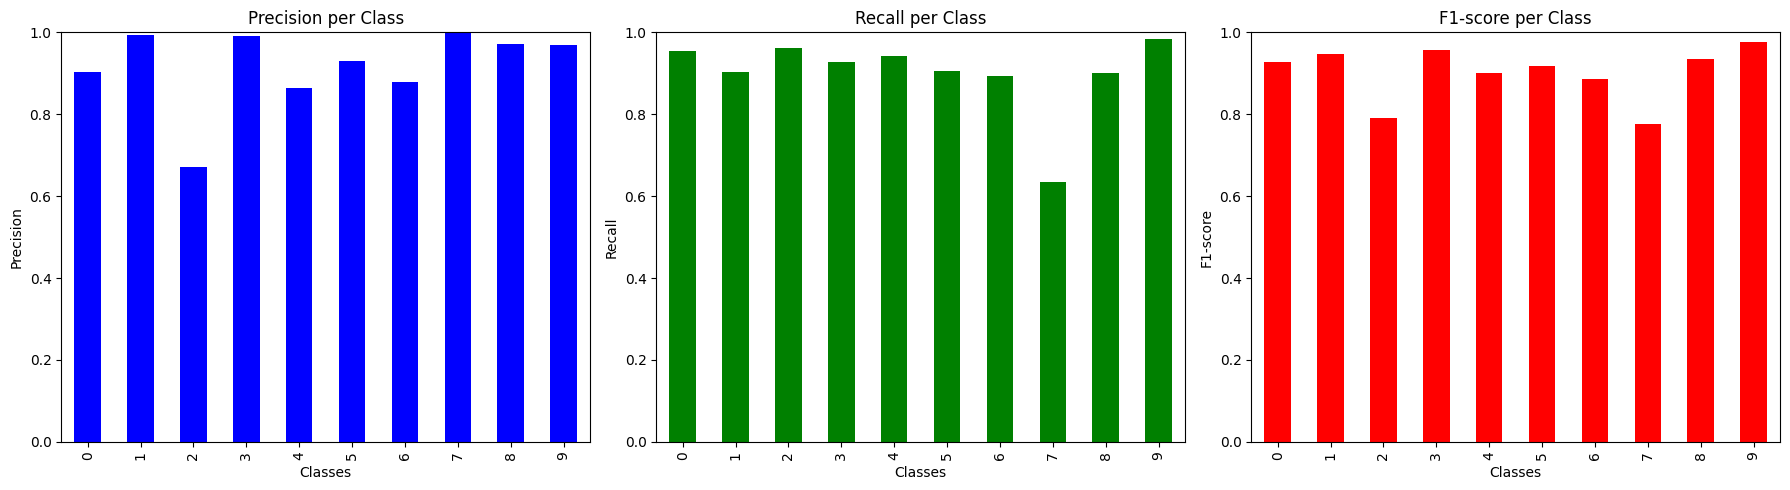

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have y_true and y_pred (true labels and model predictions)
report = classification_report(y_true, y_pred, output_dict=True)

# Convert to DataFrame
df_report = pd.DataFrame(report).transpose()

# Drop support column (not needed for plot)
df_report = df_report.drop(columns=["support"])

print(df_report)

# Plot precision, recall, and F1-score
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

metrics = ["precision", "recall", "f1-score"]
colors = ["blue", "green", "red"]

for i, metric in enumerate(metrics):
    df_report[metric][:-3].plot(kind="bar", ax=ax[i], color=colors[i])
    ax[i].set_title(f"{metric.capitalize()} per Class")
    ax[i].set_xlabel("Classes")
    ax[i].set_ylabel(metric.capitalize())
    ax[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()